In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_12/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_12.csv')
print(training_data_df.shape)
training_data_df.head()

(3490570, 318)
Wall time: 32.9 s


,전용면적,금액(만원),층,가격면적,target_log_transformed,targetarea_log_transformed,전용면적_mean,전용면적_min,전용면적_max,건물나이,year_linear,month_sin,month_cos,xnorm,ynorm,x_2nd,y_2nd,x_sin,y_sin,x_cos,y_cos,xy,trade_type,공시지가(만원),표준지여부,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,(한강)오염행위 제한지역,(한강)폐기물매립시설 설치제한지역,4대문안,가로구역별 최고높이 제한지역,가스공급설비,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가·착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고도지구,고등학교,고속철도,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공주택지구,공공지원민간임대주택 공급촉진지구,공공청사,공동구,공용시설보호지구,공원,공원마을지구(공원집단시설지구),공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,공항시설보호지구,과밀억제권역,광로1류(폭 70M 이상),광로2류(폭 50M~70M),광로3류(폭 40M~50M),광역계획구역,광장,교육환경보호구역,교통광장,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용기타용도지구,국토이용용도지구기타,근린공원,근린광장,근린상업지역,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타문화시설,기타보건위생시설,기타수도시설,기타시장시설,기타용도지역지구기타,기타용지,기타유통업무설비,기타자동차정류장,기타주차장시설,기타철도시설,기타폐기물처리시설,노외주차장,녹지,대공방어협조구역,대공방어협조구역(위탁고도54-236m),대공방어협조구역(위탁고도77-257m),대로1류(폭 35M~40M),대로2류(폭 30M~35M),대로3류(폭 25M~30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획 입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,묘지공원,문화공원,문화시설,문화재,문화재보존영향 검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,박물관,방송통신시설,방수설비,방재지구,방화지구,변전소(전원개발사업구역),변전시설,보전산지,보전임지,보존지구,보행자전용도로,부설주차장,비오톱1등급,비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방시설,사방지,사업지역기타,사업지역미분류,사회복지시설,산업개발진흥지구,산업시설구역,상대보호구역,상대정화구역,상수원보호구역,상수원보호기타,생산녹지지역,소공원,소로1류(폭 10M~12M),소로2류(폭 8M~10M),소로3류(폭 8M 미만),소하천,소하천구역,수도공급시설,수평표면구역,시·도 생태·경관보전지역,시가지경관지구,시가지조성사업지역,시도지정문화재구역,시장,시장정비구역,시장정비구역기타,아파트지구,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,완충녹지,용도구역기타,용도구역미분류,운동장,원추표면구역,원형보존지,유수지,유원지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차전용도로,자동차정류장,자연경관지구,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,저류시설,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,절대정화구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종 구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(전술항공5km),제한보호구역(후방지역500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합의료시설,주간선도로,주거용지,주거환경개선지구,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭 20M~25M),중로2류(폭 15M~20M),중로3류(폭 12M~15M),중심대광장,중심상업지역,중심지미관지구,중요시설물보존지구,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,철도,청사,청소년수련시설,체육공원,체육시설,초등학교,최고고도지구,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,토지구획정리사업지구기타,통제보호구역,통제보호구역(민통선이남300m),특수도로(보행자전용도로),특정개발진흥지구,특화경관지구,폐기물처리및재활용시설,폐기물처리시설,하수도,하수종말처리시설,하천,하천구역,학교,학교시설보호지구,학교이적지,학교환경위생 정화구역,현상변경허가 대상구역,홍수관리구역
0,4.353499,57000,0,733.118971,10.950807,6.597308,77.75,77.75,77.75,0,7.666667,-0.866025,-0.500000,0.556491,-0.904896,0.154841,0.409418,0.52821,-0.786361,0.849114,0.617768,-0.503567,0,921.0,0,0,7.063305,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4.353499,57000,0,733.118971,10.950807,6.597308,77.75,77.75,77.75,0,7.916667,-0.500000,0.866025,0.556491,-0.904896,0.154841,0.409418,0.52821,-0.786361,0.849114,0.617768,-0.503567,0,921.0,0,0,7.063305,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [3]:
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]

In [4]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')
cat_cols_df.head()

,colname
0,trade_type
1,표준지여부
2,층
3,건물나이
4,지목명


In [5]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

297

In [6]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [7]:
cat_cols

['층',
 '건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면',
 '(한강)오염행위_제한지역',
 '(한강)폐기물매립시설_설치제한지역',
 '4대문안',
 '가로구역별_최고높이_제한지역',
 '가스공급설비',
 '가축사육제한구역',
 '개발제한구역',
 '개발진흥지구',
 '개발행위허가제한지역',
 '건축선',
 '건축용도지역기타',
 '건축용도지역미분류',
 '건축허가_착공제한지역',
 '경관광장',
 '경관녹지',
 '경관지구',
 '경관지구기타',
 '고도지구',
 '고등학교',
 '고속철도',
 '공공공지',
 '공공도서관',
 '공공문화체육시설미분류',
 '공공시설구역',
 '공공주택지구',
 '공공지원민간임대주택_공급촉진지구',
 '공공청사',
 '공동구',
 '공용시설보호지구',
 '공원',
 '공원마을지구(공원집단시설지구)',
 '공원자연보존지구',
 '공원자연환경지구',
 '공익용산지',
 '공익임지',
 '공장설립승인지역',
 '공장설립제한지역',
 '공항소음피해예상지역',
 '공항시설보호지구',
 '과밀억제권역',
 '광로1류(폭_70M_이상)',
 '광로2류(폭_50M~70M)',
 '광로3류(폭_40M~50M)',
 '광역계획구역',
 '광장',
 '교육환경보호구역',
 '교통광장',
 '국가산업단지',
 '국가지정문화재구역',
 '국가하천',
 '국립공원',
 '국민임대주택단지예정지구',
 '국지도로',
 '국토이용기타용도지구',
 '국토이용용도지구기타',
 '근린공원',
 '근린광장',
 '근린상업지역',
 '기타공공공지시설',
 '기타공공청사시설',
 '기타공원시설',
 '기타교통시설',
 '기타녹지시설',
 '기타도로시설',
 '기타도시공간시설',
 '기타문화시설',
 '기타보건위생시설',
 '기타수도시설',
 '기타시장시설',
 '기타용도지역지구기타',
 '기타용지',
 '기타유통업무설비',
 '기타자

In [8]:
training_data_df.head()

,전용면적,금액(만원),층,가격면적,target_log_transformed,targetarea_log_transformed,전용면적_mean,전용면적_min,전용면적_max,건물나이,year_linear,month_sin,month_cos,xnorm,ynorm,x_2nd,y_2nd,x_sin,y_sin,x_cos,y_cos,xy,trade_type,공시지가(만원),표준지여부,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,(한강)오염행위_제한지역,(한강)폐기물매립시설_설치제한지역,4대문안,가로구역별_최고높이_제한지역,가스공급설비,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가_착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고도지구,고등학교,고속철도,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공주택지구,공공지원민간임대주택_공급촉진지구,공공청사,공동구,공용시설보호지구,공원,공원마을지구(공원집단시설지구),공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,공항시설보호지구,과밀억제권역,광로1류(폭_70M_이상),광로2류(폭_50M~70M),광로3류(폭_40M~50M),광역계획구역,광장,교육환경보호구역,교통광장,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용기타용도지구,국토이용용도지구기타,근린공원,근린광장,근린상업지역,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타문화시설,기타보건위생시설,기타수도시설,기타시장시설,기타용도지역지구기타,기타용지,기타유통업무설비,기타자동차정류장,기타주차장시설,기타철도시설,기타폐기물처리시설,노외주차장,녹지,대공방어협조구역,대공방어협조구역(위탁고도54-236m),대공방어협조구역(위탁고도77-257m),대로1류(폭_35M~40M),대로2류(폭_30M~35M),대로3류(폭_25M~30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획_입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,묘지공원,문화공원,문화시설,문화재,문화재보존영향_검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,박물관,방송통신시설,방수설비,방재지구,방화지구,변전소(전원개발사업구역),변전시설,보전산지,보전임지,보존지구,보행자전용도로,부설주차장,비오톱1등급,비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방시설,사방지,사업지역기타,사업지역미분류,사회복지시설,산업개발진흥지구,산업시설구역,상대보호구역,상대정화구역,상수원보호구역,상수원보호기타,생산녹지지역,소공원,소로1류(폭_10M~12M),소로2류(폭_8M~10M),소로3류(폭_8M_미만),소하천,소하천구역,수도공급시설,수평표면구역,시_도_생태_경관보전지역,시가지경관지구,시가지조성사업지역,시도지정문화재구역,시장,시장정비구역,시장정비구역기타,아파트지구,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,완충녹지,용도구역기타,용도구역미분류,운동장,원추표면구역,원형보존지,유수지,유원지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차전용도로,자동차정류장,자연경관지구,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,저류시설,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,절대정화구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종_구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(전술항공5km),제한보호구역(후방지역500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합의료시설,주간선도로,주거용지,주거환경개선지구,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭_20M~25M),중로2류(폭_15M~20M),중로3류(폭_12M~15M),중심대광장,중심상업지역,중심지미관지구,중요시설물보존지구,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,철도,청사,청소년수련시설,체육공원,체육시설,초등학교,최고고도지구,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,토지구획정리사업지구기타,통제보호구역,통제보호구역(민통선이남300m),특수도로(보행자전용도로),특정개발진흥지구,특화경관지구,폐기물처리및재활용시설,폐기물처리시설,하수도,하수종말처리시설,하천,하천구역,학교,학교시설보호지구,학교이적지,학교환경위생_정화구역,현상변경허가_대상구역,홍수관리구역
0,4.353499,57000,0,733.118971,10.950807,6.597308,77.75,77.75,77.75,0,7.666667,-0.866025,-0.500000,0.556491,-0.904896,0.154841,0.409418,0.52821,-0.786361,0.849114,0.617768,-0.503567,0,921.0,0,0,7.063305,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4.353499,57000,0,733.118971,10.950807,6.597308,77.75,77.75,77.75,0,7.916667,-0.500000,0.866025,0.556491,-0.904896,0.154841,0.409418,0.52821,-0.786361,0.849114,0.617768,-0.503567,0,921.0,0,0,7.063305,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [9]:
test_data = training_data_df.sample(frac=0.2)
train_data = training_data_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

(698114, 318)
(558491, 318)
(2233965, 318)


In [10]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed']#, 'land_area_log']

In [11]:
x_test = test_data.drop(columns=target_cols)
y_test = test_data['가격면적']
print(x_test.shape)
print(y_test.shape)

(698114, 314)
(698114,)


In [12]:
x_valid = valid_data.drop(columns=target_cols)
y_valid = valid_data['가격면적']
print(x_valid.shape)
print(y_valid.shape)

(558491, 314)
(558491,)


In [13]:
x_train = train_data.drop(columns=target_cols)
y_train = train_data['가격면적']
print(x_train.shape)
print(y_train.shape)

(2233965, 314)
(2233965,)


<AxesSubplot:>

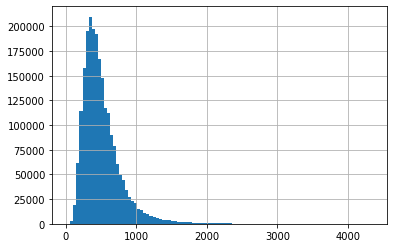

In [14]:
y_train.hist(bins=100)

# Training

In [15]:
from sklearn.metrics import r2_score

# ML Models

# Light GBM

In [16]:
import lightgbm as lgb

In [17]:
params = {
    'objective':'regression',
    'learning_rate': 0.03,
    'seed': 42,
    'max_depth': -1,
    'num_leaves':31,
    'lambda_l2':0,
    'metric':'rmse'
}

In [18]:
train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
valid_dataset = lgb.Dataset(x_valid, label=y_valid, categorical_feature=cat_cols)

In [19]:
# without 토지면적 log
num_rounds = 500000

bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[valid_dataset], early_stopping_rounds=200, verbose_eval=50)

c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.447653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5006
[LightGBM] [Info] Number of data points in the train set: 2233965, number of used features: 307


c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 508.157253
Training until validation scores don't improve for 200 rounds
[50]	valid_0's rmse: 148.758
[100]	valid_0's rmse: 121.294
[150]	valid_0's rmse: 109.858
[200]	valid_0's rmse: 103.577
[250]	valid_0's rmse: 99.7101
[300]	valid_0's rmse: 96.9128
[350]	valid_0's rmse: 94.5973
[400]	valid_0's rmse: 92.744
[450]	valid_0's rmse: 91.1917
[500]	valid_0's rmse: 89.8359
[550]	valid_0's rmse: 88.6509
[600]	valid_0's rmse: 87.604
[650]	valid_0's rmse: 86.688
[700]	valid_0's rmse: 85.885
[750]	valid_0's rmse: 85.0875
[800]	valid_0's rmse: 84.3714
[850]	valid_0's rmse: 83.6714
[900]	valid_0's rmse: 83.0686
[950]	valid_0's rmse: 82.4359
[1000]	valid_0's rmse: 81.9133
[1050]	valid_0's rmse: 81.4007
[1100]	valid_0's rmse: 80.8864
[1150]	valid_0's rmse: 80.4017
[1200]	valid_0's rmse: 79.9256
[1250]	valid_0's rmse: 79.4751
[1300]	valid_0's rmse: 79.0346
[1350]	valid_0's rmse: 78.6428
[1400]	valid_0's rmse: 78.2238
[1450]	valid_0's rmse: 77.8378
[1500]	v

[13050]	valid_0's rmse: 60.2213
[13100]	valid_0's rmse: 60.2019
[13150]	valid_0's rmse: 60.1777
[13200]	valid_0's rmse: 60.158
[13250]	valid_0's rmse: 60.1354
[13300]	valid_0's rmse: 60.1161
[13350]	valid_0's rmse: 60.0946
[13400]	valid_0's rmse: 60.07
[13450]	valid_0's rmse: 60.0494
[13500]	valid_0's rmse: 60.0245
[13550]	valid_0's rmse: 60.0028
[13600]	valid_0's rmse: 59.9797
[13650]	valid_0's rmse: 59.9561
[13700]	valid_0's rmse: 59.9362
[13750]	valid_0's rmse: 59.9176
[13800]	valid_0's rmse: 59.8928
[13850]	valid_0's rmse: 59.8699
[13900]	valid_0's rmse: 59.8523
[13950]	valid_0's rmse: 59.8343
[14000]	valid_0's rmse: 59.8141
[14050]	valid_0's rmse: 59.7912
[14100]	valid_0's rmse: 59.7693
[14150]	valid_0's rmse: 59.75
[14200]	valid_0's rmse: 59.7277
[14250]	valid_0's rmse: 59.7086
[14300]	valid_0's rmse: 59.6918
[14350]	valid_0's rmse: 59.6689
[14400]	valid_0's rmse: 59.6499
[14450]	valid_0's rmse: 59.6281
[14500]	valid_0's rmse: 59.6101
[14550]	valid_0's rmse: 59.5898
[14600]	valid

[25900]	valid_0's rmse: 56.5234
[25950]	valid_0's rmse: 56.5126
[26000]	valid_0's rmse: 56.5026
[26050]	valid_0's rmse: 56.4949
[26100]	valid_0's rmse: 56.4866
[26150]	valid_0's rmse: 56.4782
[26200]	valid_0's rmse: 56.4699
[26250]	valid_0's rmse: 56.4617
[26300]	valid_0's rmse: 56.4542
[26350]	valid_0's rmse: 56.4456
[26400]	valid_0's rmse: 56.4392
[26450]	valid_0's rmse: 56.4296
[26500]	valid_0's rmse: 56.4226
[26550]	valid_0's rmse: 56.4145
[26600]	valid_0's rmse: 56.4059
[26650]	valid_0's rmse: 56.3985
[26700]	valid_0's rmse: 56.3911
[26750]	valid_0's rmse: 56.3825
[26800]	valid_0's rmse: 56.3735
[26850]	valid_0's rmse: 56.3648
[26900]	valid_0's rmse: 56.3557
[26950]	valid_0's rmse: 56.3459
[27000]	valid_0's rmse: 56.3371
[27050]	valid_0's rmse: 56.3267
[27100]	valid_0's rmse: 56.3178
[27150]	valid_0's rmse: 56.3088
[27200]	valid_0's rmse: 56.3004
[27250]	valid_0's rmse: 56.2923
[27300]	valid_0's rmse: 56.2843
[27350]	valid_0's rmse: 56.2763
[27400]	valid_0's rmse: 56.2679
[27450]	

[38750]	valid_0's rmse: 54.7913
[38800]	valid_0's rmse: 54.7853
[38850]	valid_0's rmse: 54.7792
[38900]	valid_0's rmse: 54.7741
[38950]	valid_0's rmse: 54.7707
[39000]	valid_0's rmse: 54.7667
[39050]	valid_0's rmse: 54.7624
[39100]	valid_0's rmse: 54.7584
[39150]	valid_0's rmse: 54.7531
[39200]	valid_0's rmse: 54.7483
[39250]	valid_0's rmse: 54.7438
[39300]	valid_0's rmse: 54.74
[39350]	valid_0's rmse: 54.7351
[39400]	valid_0's rmse: 54.7294
[39450]	valid_0's rmse: 54.7234
[39500]	valid_0's rmse: 54.7183
[39550]	valid_0's rmse: 54.7137
[39600]	valid_0's rmse: 54.7088
[39650]	valid_0's rmse: 54.7043
[39700]	valid_0's rmse: 54.7001
[39750]	valid_0's rmse: 54.6947
[39800]	valid_0's rmse: 54.6904
[39850]	valid_0's rmse: 54.6856
[39900]	valid_0's rmse: 54.6808
[39950]	valid_0's rmse: 54.6765
[40000]	valid_0's rmse: 54.672
[40050]	valid_0's rmse: 54.6673
[40100]	valid_0's rmse: 54.6629
[40150]	valid_0's rmse: 54.6583
[40200]	valid_0's rmse: 54.6541
[40250]	valid_0's rmse: 54.6496
[40300]	val

[51600]	valid_0's rmse: 53.7931
[51650]	valid_0's rmse: 53.7901
[51700]	valid_0's rmse: 53.7875
[51750]	valid_0's rmse: 53.7833
[51800]	valid_0's rmse: 53.7806
[51850]	valid_0's rmse: 53.7779
[51900]	valid_0's rmse: 53.7748
[51950]	valid_0's rmse: 53.7723
[52000]	valid_0's rmse: 53.7695
[52050]	valid_0's rmse: 53.7673
[52100]	valid_0's rmse: 53.7649
[52150]	valid_0's rmse: 53.7621
[52200]	valid_0's rmse: 53.7585
[52250]	valid_0's rmse: 53.7555
[52300]	valid_0's rmse: 53.7528
[52350]	valid_0's rmse: 53.7505
[52400]	valid_0's rmse: 53.7475
[52450]	valid_0's rmse: 53.744
[52500]	valid_0's rmse: 53.7412
[52550]	valid_0's rmse: 53.7385
[52600]	valid_0's rmse: 53.7346
[52650]	valid_0's rmse: 53.7311
[52700]	valid_0's rmse: 53.7261
[52750]	valid_0's rmse: 53.7231
[52800]	valid_0's rmse: 53.7202
[52850]	valid_0's rmse: 53.7177
[52900]	valid_0's rmse: 53.7147
[52950]	valid_0's rmse: 53.7114
[53000]	valid_0's rmse: 53.709
[53050]	valid_0's rmse: 53.7059
[53100]	valid_0's rmse: 53.7021
[53150]	va

[64500]	valid_0's rmse: 53.1229
[64550]	valid_0's rmse: 53.1209
[64600]	valid_0's rmse: 53.1187
[64650]	valid_0's rmse: 53.1165
[64700]	valid_0's rmse: 53.1145
[64750]	valid_0's rmse: 53.1115
[64800]	valid_0's rmse: 53.1093
[64850]	valid_0's rmse: 53.1068
[64900]	valid_0's rmse: 53.1042
[64950]	valid_0's rmse: 53.1022
[65000]	valid_0's rmse: 53.0998
[65050]	valid_0's rmse: 53.0972
[65100]	valid_0's rmse: 53.0951
[65150]	valid_0's rmse: 53.093
[65200]	valid_0's rmse: 53.0903
[65250]	valid_0's rmse: 53.0887
[65300]	valid_0's rmse: 53.0866
[65350]	valid_0's rmse: 53.0849
[65400]	valid_0's rmse: 53.0834
[65450]	valid_0's rmse: 53.0806
[65500]	valid_0's rmse: 53.0781
[65550]	valid_0's rmse: 53.0753
[65600]	valid_0's rmse: 53.0732
[65650]	valid_0's rmse: 53.0704
[65700]	valid_0's rmse: 53.0682
[65750]	valid_0's rmse: 53.0658
[65800]	valid_0's rmse: 53.0635
[65850]	valid_0's rmse: 53.0612
[65900]	valid_0's rmse: 53.059
[65950]	valid_0's rmse: 53.0558
[66000]	valid_0's rmse: 53.0539
[66050]	va

[77400]	valid_0's rmse: 52.6365
[77450]	valid_0's rmse: 52.6347
[77500]	valid_0's rmse: 52.6334
[77550]	valid_0's rmse: 52.6316
[77600]	valid_0's rmse: 52.6302
[77650]	valid_0's rmse: 52.6289
[77700]	valid_0's rmse: 52.6278
[77750]	valid_0's rmse: 52.6267
[77800]	valid_0's rmse: 52.6255
[77850]	valid_0's rmse: 52.6239
[77900]	valid_0's rmse: 52.6222
[77950]	valid_0's rmse: 52.6207
[78000]	valid_0's rmse: 52.6192
[78050]	valid_0's rmse: 52.6178
[78100]	valid_0's rmse: 52.6162
[78150]	valid_0's rmse: 52.6143
[78200]	valid_0's rmse: 52.6134
[78250]	valid_0's rmse: 52.6124
[78300]	valid_0's rmse: 52.6108
[78350]	valid_0's rmse: 52.6094
[78400]	valid_0's rmse: 52.6081
[78450]	valid_0's rmse: 52.6064
[78500]	valid_0's rmse: 52.605
[78550]	valid_0's rmse: 52.6035
[78600]	valid_0's rmse: 52.6017
[78650]	valid_0's rmse: 52.5997
[78700]	valid_0's rmse: 52.5977
[78750]	valid_0's rmse: 52.5961
[78800]	valid_0's rmse: 52.5942
[78850]	valid_0's rmse: 52.5925
[78900]	valid_0's rmse: 52.5913
[78950]	v

[90250]	valid_0's rmse: 52.2937
[90300]	valid_0's rmse: 52.2925
[90350]	valid_0's rmse: 52.2912
[90400]	valid_0's rmse: 52.2899
[90450]	valid_0's rmse: 52.289
[90500]	valid_0's rmse: 52.2876
[90550]	valid_0's rmse: 52.2859
[90600]	valid_0's rmse: 52.2844
[90650]	valid_0's rmse: 52.2833
[90700]	valid_0's rmse: 52.2832
[90750]	valid_0's rmse: 52.2824
[90800]	valid_0's rmse: 52.2815
[90850]	valid_0's rmse: 52.2802
[90900]	valid_0's rmse: 52.2789
[90950]	valid_0's rmse: 52.2774
[91000]	valid_0's rmse: 52.277
[91050]	valid_0's rmse: 52.2756
[91100]	valid_0's rmse: 52.2743
[91150]	valid_0's rmse: 52.2733
[91200]	valid_0's rmse: 52.2725
[91250]	valid_0's rmse: 52.2714
[91300]	valid_0's rmse: 52.2706
[91350]	valid_0's rmse: 52.2699
[91400]	valid_0's rmse: 52.2686
[91450]	valid_0's rmse: 52.2678
[91500]	valid_0's rmse: 52.2667
[91550]	valid_0's rmse: 52.2649
[91600]	valid_0's rmse: 52.2639
[91650]	valid_0's rmse: 52.2628
[91700]	valid_0's rmse: 52.2619
[91750]	valid_0's rmse: 52.2609
[91800]	va

[103050]	valid_0's rmse: 52.0198
[103100]	valid_0's rmse: 52.0188
[103150]	valid_0's rmse: 52.0179
[103200]	valid_0's rmse: 52.0172
[103250]	valid_0's rmse: 52.0166
[103300]	valid_0's rmse: 52.0155
[103350]	valid_0's rmse: 52.0147
[103400]	valid_0's rmse: 52.014
[103450]	valid_0's rmse: 52.0131
[103500]	valid_0's rmse: 52.0125
[103550]	valid_0's rmse: 52.0111
[103600]	valid_0's rmse: 52.0103
[103650]	valid_0's rmse: 52.0097
[103700]	valid_0's rmse: 52.0088
[103750]	valid_0's rmse: 52.0082
[103800]	valid_0's rmse: 52.0073
[103850]	valid_0's rmse: 52.006
[103900]	valid_0's rmse: 52.0047
[103950]	valid_0's rmse: 52.0041
[104000]	valid_0's rmse: 52.003
[104050]	valid_0's rmse: 52.002
[104100]	valid_0's rmse: 52.001
[104150]	valid_0's rmse: 52.0001
[104200]	valid_0's rmse: 51.9993
[104250]	valid_0's rmse: 51.9985
[104300]	valid_0's rmse: 51.9972
[104350]	valid_0's rmse: 51.9965
[104400]	valid_0's rmse: 51.996
[104450]	valid_0's rmse: 51.9951
[104500]	valid_0's rmse: 51.9945
[104550]	valid_0

[115550]	valid_0's rmse: 51.8246
[115600]	valid_0's rmse: 51.8239
[115650]	valid_0's rmse: 51.8231
[115700]	valid_0's rmse: 51.8225
[115750]	valid_0's rmse: 51.8215
[115800]	valid_0's rmse: 51.8208
[115850]	valid_0's rmse: 51.8204
[115900]	valid_0's rmse: 51.8197
[115950]	valid_0's rmse: 51.8193
[116000]	valid_0's rmse: 51.8184
[116050]	valid_0's rmse: 51.818
[116100]	valid_0's rmse: 51.8174
[116150]	valid_0's rmse: 51.8169
[116200]	valid_0's rmse: 51.8163
[116250]	valid_0's rmse: 51.8154
[116300]	valid_0's rmse: 51.8144
[116350]	valid_0's rmse: 51.8131
[116400]	valid_0's rmse: 51.8121
[116450]	valid_0's rmse: 51.8114
[116500]	valid_0's rmse: 51.8105
[116550]	valid_0's rmse: 51.8103
[116600]	valid_0's rmse: 51.8093
[116650]	valid_0's rmse: 51.8084
[116700]	valid_0's rmse: 51.8076
[116750]	valid_0's rmse: 51.8065
[116800]	valid_0's rmse: 51.8057
[116850]	valid_0's rmse: 51.8052
[116900]	valid_0's rmse: 51.8043
[116950]	valid_0's rmse: 51.8034
[117000]	valid_0's rmse: 51.8029
[117050]	va

[128000]	valid_0's rmse: 51.6715
[128050]	valid_0's rmse: 51.6711
[128100]	valid_0's rmse: 51.6709
[128150]	valid_0's rmse: 51.6702
[128200]	valid_0's rmse: 51.6699
[128250]	valid_0's rmse: 51.6695
[128300]	valid_0's rmse: 51.6692
[128350]	valid_0's rmse: 51.6689
[128400]	valid_0's rmse: 51.6686
[128450]	valid_0's rmse: 51.6678
[128500]	valid_0's rmse: 51.6669
[128550]	valid_0's rmse: 51.6664
[128600]	valid_0's rmse: 51.6657
[128650]	valid_0's rmse: 51.6653
[128700]	valid_0's rmse: 51.6647
[128750]	valid_0's rmse: 51.6641
[128800]	valid_0's rmse: 51.6634
[128850]	valid_0's rmse: 51.6629
[128900]	valid_0's rmse: 51.6623
[128950]	valid_0's rmse: 51.6615
[129000]	valid_0's rmse: 51.661
[129050]	valid_0's rmse: 51.6605
[129100]	valid_0's rmse: 51.6599
[129150]	valid_0's rmse: 51.6594
[129200]	valid_0's rmse: 51.6591
[129250]	valid_0's rmse: 51.6584
[129300]	valid_0's rmse: 51.6579
[129350]	valid_0's rmse: 51.6577
[129400]	valid_0's rmse: 51.6574
[129450]	valid_0's rmse: 51.6565
[129500]	va

[140500]	valid_0's rmse: 51.5433
[140550]	valid_0's rmse: 51.5429
[140600]	valid_0's rmse: 51.5425
[140650]	valid_0's rmse: 51.5419
[140700]	valid_0's rmse: 51.5414
[140750]	valid_0's rmse: 51.5408
[140800]	valid_0's rmse: 51.5404
[140850]	valid_0's rmse: 51.5398
[140900]	valid_0's rmse: 51.5395
[140950]	valid_0's rmse: 51.539
[141000]	valid_0's rmse: 51.5378
[141050]	valid_0's rmse: 51.5374
[141100]	valid_0's rmse: 51.5367
[141150]	valid_0's rmse: 51.536
[141200]	valid_0's rmse: 51.5354
[141250]	valid_0's rmse: 51.5349
[141300]	valid_0's rmse: 51.5344
[141350]	valid_0's rmse: 51.5343
[141400]	valid_0's rmse: 51.5339
[141450]	valid_0's rmse: 51.5333
[141500]	valid_0's rmse: 51.5328
[141550]	valid_0's rmse: 51.5325
[141600]	valid_0's rmse: 51.532
[141650]	valid_0's rmse: 51.5315
[141700]	valid_0's rmse: 51.5308
[141750]	valid_0's rmse: 51.5307
[141800]	valid_0's rmse: 51.5306
[141850]	valid_0's rmse: 51.53
[141900]	valid_0's rmse: 51.5294
[141950]	valid_0's rmse: 51.5292
[142000]	valid_

[153000]	valid_0's rmse: 51.4278
[153050]	valid_0's rmse: 51.4275
[153100]	valid_0's rmse: 51.427
[153150]	valid_0's rmse: 51.4269
[153200]	valid_0's rmse: 51.4267
[153250]	valid_0's rmse: 51.426
[153300]	valid_0's rmse: 51.4257
[153350]	valid_0's rmse: 51.4248
[153400]	valid_0's rmse: 51.4245
[153450]	valid_0's rmse: 51.4244
[153500]	valid_0's rmse: 51.4238
[153550]	valid_0's rmse: 51.4237
[153600]	valid_0's rmse: 51.4234
[153650]	valid_0's rmse: 51.4231
[153700]	valid_0's rmse: 51.4223
[153750]	valid_0's rmse: 51.4217
[153800]	valid_0's rmse: 51.4212
[153850]	valid_0's rmse: 51.4206
[153900]	valid_0's rmse: 51.42
[153950]	valid_0's rmse: 51.4192
[154000]	valid_0's rmse: 51.4189
[154050]	valid_0's rmse: 51.4182
[154100]	valid_0's rmse: 51.4177
[154150]	valid_0's rmse: 51.417
[154200]	valid_0's rmse: 51.4166
[154250]	valid_0's rmse: 51.4161
[154300]	valid_0's rmse: 51.4158
[154350]	valid_0's rmse: 51.4153
[154400]	valid_0's rmse: 51.4148
[154450]	valid_0's rmse: 51.4142
[154500]	valid_

[165450]	valid_0's rmse: 51.3386
[165500]	valid_0's rmse: 51.3381
[165550]	valid_0's rmse: 51.3379
[165600]	valid_0's rmse: 51.3376
[165650]	valid_0's rmse: 51.3372
[165700]	valid_0's rmse: 51.3371
[165750]	valid_0's rmse: 51.3365
[165800]	valid_0's rmse: 51.336
[165850]	valid_0's rmse: 51.3358
[165900]	valid_0's rmse: 51.3356
[165950]	valid_0's rmse: 51.3354
[166000]	valid_0's rmse: 51.3351
[166050]	valid_0's rmse: 51.3347
[166100]	valid_0's rmse: 51.3347
[166150]	valid_0's rmse: 51.3344
[166200]	valid_0's rmse: 51.334
[166250]	valid_0's rmse: 51.3336
[166300]	valid_0's rmse: 51.333
[166350]	valid_0's rmse: 51.3326
[166400]	valid_0's rmse: 51.3323
[166450]	valid_0's rmse: 51.3321
[166500]	valid_0's rmse: 51.3319
[166550]	valid_0's rmse: 51.3314
[166600]	valid_0's rmse: 51.3308
[166650]	valid_0's rmse: 51.3305
[166700]	valid_0's rmse: 51.3299
[166750]	valid_0's rmse: 51.3294
[166800]	valid_0's rmse: 51.3291
[166850]	valid_0's rmse: 51.3287
[166900]	valid_0's rmse: 51.3282
[166950]	vali

[177900]	valid_0's rmse: 51.2629
[177950]	valid_0's rmse: 51.2627
[178000]	valid_0's rmse: 51.2625
[178050]	valid_0's rmse: 51.262
[178100]	valid_0's rmse: 51.2617
[178150]	valid_0's rmse: 51.2611
[178200]	valid_0's rmse: 51.2606
[178250]	valid_0's rmse: 51.2601
[178300]	valid_0's rmse: 51.2595
[178350]	valid_0's rmse: 51.2592
[178400]	valid_0's rmse: 51.2588
[178450]	valid_0's rmse: 51.2585
[178500]	valid_0's rmse: 51.258
[178550]	valid_0's rmse: 51.2578
[178600]	valid_0's rmse: 51.2574
[178650]	valid_0's rmse: 51.2573
[178700]	valid_0's rmse: 51.2571
[178750]	valid_0's rmse: 51.2571
[178800]	valid_0's rmse: 51.2569
[178850]	valid_0's rmse: 51.2567
[178900]	valid_0's rmse: 51.2567
[178950]	valid_0's rmse: 51.2562
[179000]	valid_0's rmse: 51.2559
[179050]	valid_0's rmse: 51.2555
[179100]	valid_0's rmse: 51.255
[179150]	valid_0's rmse: 51.2547
[179200]	valid_0's rmse: 51.2543
[179250]	valid_0's rmse: 51.2541
[179300]	valid_0's rmse: 51.254
[179350]	valid_0's rmse: 51.2536
[179400]	valid

In [25]:
import shap

In [26]:
explainer = shap.TreeExplainer(bst)

In [27]:
sample_df = x_valid.sample(n=1000)

In [28]:
shap_values = explainer.shap_values(sample_df)

In [29]:
shap_values_df = pd.DataFrame(shap_values)

In [37]:
shap_summary_df = pd.DataFrame()

In [38]:
for col in shap_values_df.columns:
    shap_summary_df[col] = [np.mean(np.abs(shap_values_df[col].values))]

In [39]:
shap_summary_df.columns = x_valid.columns

In [40]:
shap_summary_df = shap_summary_df.transpose().sort_values(0, ascending=False)

In [41]:
shap_summary_df.head(50)

,0
trade_type,109.774977
year_linear,77.459899
공시지가(만원),76.615004
토지면적,45.251741
건물나이,42.070958
전용면적,35.462071
ynorm,35.015052
xy,23.358086
층,11.476070
x_2nd,10.637957


In [42]:
under_zero_df = over_zero_df = shap_summary_df[shap_summary_df[0] <= 0]
under_zero_df.shape

(18, 1)

In [43]:
under_zero_df

,0
소하천,0.0
중요시설물보호지구,0.0
건축용도지역미분류,0.0
가스공급설비,0.0
상수원보호구역,0.0
박물관,0.0
y_sin,0.0
시_도_생태_경관보전지역,0.0
경관광장,0.0
시가지경관지구,0.0


In [44]:
over_zero_df = shap_summary_df[shap_summary_df[0] > 0]
over_zero_df.shape

(296, 1)

In [35]:
over_zero_df = over_zero_df.transpose()
over_zero_df.head()

,trade_type,year_linear,공시지가(만원),토지면적,건물나이,전용면적,ynorm,xy,층,x_2nd,x_cos,토지이동상황,xnorm,전용면적_mean,전용면적_max,아파트지구,전용면적_min,y_2nd,용도지역명1,도로접면,가축사육제한구역,y_cos,지형높이,지구단위계획구역,공원,(한강)폐기물매립시설_설치제한지역,정비구역,month_sin,지형형상,도시관리계획_입안중,학교환경위생_정화구역,중점경관관리구역,교육환경보호구역,제1종지구단위계획구역,제3종일반주거지역,제1종일반주거지역,도시지역,제2종일반주거지역,진입표면구역,대공방어협조구역(위탁고도77-257m),month_cos,일반상업지역,재정비촉진지구,녹지,상대보호구역,용도지역명2,상대정화구역,장애물제한표면구역,일반미관지구,자연경관지구,중로2류(폭_15M~20M),도로,자연녹지지역,비행안전제2구역(전술),학교,공장설립승인지역,근린공원,가로구역별_최고높이_제한지역,대로3류(폭_25M~30M),건축선,준보전산지,역사문화미관지구,상수원보호기타,토지거래계약에관한허가구역,비행안전제3구역(전술),준공업지역,절대보호구역,역사도심,소로3류(폭_8M_미만),개발행위허가제한지역,국민임대주택단지예정지구,재개발구역,중심지미관지구,주거용지,공장설립제한지역,완충녹지,도시철도,제한보호구역(후방지역500m),용도구역기타,광장,절대정화구역,경관지구,대공방어협조구역,소로2류(폭_8M~10M),경관녹지,공공공지,하천구역,어린이공원,준주거지역,도시기타용도지역지구기타,소로1류(폭_10M~12M),철도,제한보호구역(전술항공5km),표준지여부,학교이적지,수평표면구역,최고고도지구,중로1류(폭_20M~25M),비오톱1등급,중요시설물보호지구(공항),공공청사,건축허가_착공제한지역,택지개발예정지구,중로3류(폭_12M~15M),정비구역기타,보행자전용도로,역사문화특화경관지구,하천,공익용산지,원추표면구역,연결녹지,하수도,고도지구,방화지구,과밀억제권역,일반도로,지목명,공항시설보호지구,유수지,국토이용용도지구기타,대공방어협조구역(위탁고도54-236m),광로2류(폭_50M~70M),사회복지시설,건축용도지역기타,도시개발구역,사업지역기타,지역특화발전특구,대로1류(폭_35M~40M),학교시설보호지구,운동장,제3종_구역,도시기타용도지역지구미분류,x_sin,방재지구,기타녹지시설,기타철도시설,전통사찰보존구역,역사문화환경보존지역,일단의주택단지조성사업지역,보전산지,도시자연공원구역,도로구역,광로3류(폭_40M~50M),공용시설보호지구,광로1류(폭_70M_이상),문화시설,비행안전제6구역(전술),경관지구기타,주차장,산업시설구역,제1종전용주거지역,비행안전제3구역(지원),공항소음피해예상지역,일반철도,지하도로,지원시설구역,중요시설물보호지구(공용),고등학교,유통업무설비,공공주택지구,대로2류(폭_30M~35M),조례로정한지역,시장,전기공급설비,근린상업지역,재정비촉진지구기타,조망가로특화경관지구,연구시설,4대문안,문화재보존영향_검토대상구역,도시자연공원,도시지역기타,사방지,온천공보호구역,고속철도,자연재해위험지구,특정개발진흥지구,산업개발진흥지구,수도공급시설,보전임지,초등학교,임업용산지,비행안전제2구역(지원),현상변경허가_대상구역,광역계획구역,조망가로미관지구,소공원,기타도로시설,침수위험지구,공익임지,공동구,공공도서관,중학교,비행안전제4구역(지원),도서관,용도구역미분류,주차환경개선지구,비행안전제5구역(지원),유통상업지역,생산녹지지역,야생생물보호구역,국가산업단지,기타공원시설,문화재,문화지구,문화재보호구역,개발제한구역,중심상업지역,일반주거지역,부설주차장,유치원,재개발구역기타,노외주차장,비행안전제5구역(전술),기타용도지역지구기타,도시개발구역기타,택지개발예정지구기타,청소년수련시설,국립공원,기타유통업무설비,공공문화체육시설미분류,제한보호구역,여객자동차터미널,(한강)오염행위_제한지역,국지도로,국가지정문화재구역,근린광장,개발진흥지구,유통단지,특화경관지구,기타주차장시설,자동차정류장,정비예정구역,지하광장,방수설비,기타도시공간시설,주거환경개선지구,공원자연환경지구,교통광장,하수종말처리시설,국가하천,제방,기타시장시설,열공급설비,시장정비구역,주간선도로,사고지,체육시설,청사,국토이용기타용도지구,종합의료시설,자동차전용도로,기타자동차정류장,연구개발특구,폐기물처리및재활용시설,공공시설구역,제2종전용주거지역,특수도로(보행자전용도로),기타폐기물처리시설,대학,묘지공원,방송통신시설,공공지원민간임대주택_공급촉진지구,도시고속도로,변전시설,시가지조성사업지역,지정문화재구역,중심대광장,소하천구역,사방시설,폐기물처리시설,기타교통시설,문화재보호구역기타,기타문화시설,변전소(전원개발사업구역),도시기타용도지역지구용도지역지구,홍수관리구역,통제보호구역(민통선이남300m),기타용지,원형보존지,통제보호구역,문화공원,사업지역미분류,중요시설물보존지구,자동차검사시설,시도지정문화재구역,일단의공업용지조성사업지역,저류시설,전이표면구역,기타수도시설,주차장기타,일반산업단지,시장정비구역기타,공원마을지구(공원집단시설지구),집단취락지구,공원자연보존지구
0,109.774977,77.459899,76.615004,45.251741,42.070958,35.462071,35.015052,23.358086,11.47607,10.637957,8.97589,8.136276,7.731156,7.473755,6.323813,5.49697,5.439913,5.191114,5.108964,4.983375,3.953606,3.267503,2.952337,2.757723,2.526545,2.364342,2.263325,1.977137,1.792243,1.592266,1.577086,1.434471,1.414975,1.317211,1.305299,1.302033,1.261783,1.250539,1.138919,1.081058,0.964585,0.881457,0.85238,0.845041,0.720116,0.707626,0.6669,0.635544,0.610052,0.588331,0.581085,0.567734,0.528927,0.527335,0.509149,0.496126,0.494678,0.479153,0.477879,0.440037,0.417557,0.416376,0.414502,0.40076,0.395382,0.352761,0.321233,0.318768,0.317252,0.291533,0.281404,0.268153,0.258418,0.245435,0.241322,0.23751,0.235638,0.225565,0.218846,0.218151,0.217769,0.217151,0.215445,0.214296,0.208759,0.20175,0.194264,0.193998,0.183387,0.178617,0.176791,0.17168,0.171442,0.170391,0.163312,0.160581,0.158489,0.158478,0.156151,0.155145,0.153368,0.152061,0.148205,0.146278,0.139174,0.137662,0.133019,0.128982,0.125607,0.124795,0.122195,0.120869,0.118894,0.117634,0.112447,0.105819,0.103323,0.102991,0.101904,0.100984,0.100946,0.096738,0.091367,0.089415,0.087095,0.085584,0.085385,0.081029,0.080936,0.079054,0.072667,0.071942,0.070003,0.068993,0.062313,0.062068,0.06103,0.058681,0.058367,0.058336,0.055062,0.054096,0.05349,0.051983,0.050846,0.049446,0.045705,0.045681,0.043809,0.042924,0.041367,0.040836,0.039288,0.03927,0.038922,0.038868,0.037919,0.037349,0.035602,0.034947,0.034531,0.03412,0.03399,0.033476,0.033323,0.0332,0.032735,0.032533,0.030461,0.029793,0.029764,0.029426,0.028448,0.027883,0.025965,0.024665,0.024637,0

In [45]:
over_zero_df.to_csv(basedir + 'over_zero_shap_score_features.csv', index=False)

In [36]:
selected_features = over_zero_df.columns.tolist()

In [ ]:
test_data = training_data_df.sample(frac=0.2)
train_data = training_data_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

In [ ]:
x_test = test_data[selected_features]
y_test = test_data['가격면적']
print(x_test.shape)
print(y_test.shape)

In [ ]:
x_valid = valid_data[selected_features]
y_valid = valid_data['가격면적']
print(x_valid.shape)
print(y_valid.shape)

In [ ]:
x_train = train_data[selected_features]
y_train = train_data['가격면적']
print(x_train.shape)
print(y_train.shape)

In [ ]:
y_train.hist(bins=100)

In [ ]:
import lightgbm as lgb

In [ ]:
params = {
    'objective':'regression',
    'learning_rate': 0.03,
    'seed': 42,
    'max_depth': -1,
    'num_leaves':31,
    'lambda_l2':0,
    'metric':'rmse',
    'tree_learner':'feature'
}

In [ ]:
cat_cols = [col for col in cat_cols if col in selected_features]
len(cat_cols)

In [ ]:
train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
valid_dataset = lgb.Dataset(x_valid, label=y_valid, categorical_feature=cat_cols)

In [ ]:
# without 토지면적 log
num_rounds = 500000

bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[valid_dataset], early_stopping_rounds=5000, verbose_eval=50)

In [ ]:
lgb.plot_importance(bst)

In [ ]:
preds = bst.predict(x_test, num_iteration=bst.best_iteration)

In [ ]:
bst.save_model('lgb_model_for_training_data_ver_8.txt')

In [ ]:
pd.DataFrame(y_test).to_csv('y_test_training_data_ver_8.csv', index=False)

In [ ]:
pd.DataFrame({'preds':preds}).to_csv('lgb_preds_training_data_ver_8.csv', index=False)

In [ ]:
y_test_pricearea = test_data['가격/면적']

In [ ]:
r2_score(y_test, preds)

In [ ]:
r2_score(y_test_pricearea, np.e**preds)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_test, preds)

In [ ]:
mean_squared_error(y_test_pricearea, np.e**preds)

In [ ]:
compare_df = pd.DataFrame({'y_test':y_test, 'preds':preds})
print(compare_df.shape)
compare_df.head(50)

In [ ]:
compare_df.tail()

In [ ]:
mean_squared_error(y_test, pred)

In [ ]:
from sklearn.metrics import mean_squared_log_error

In [ ]:
mean_squared_log_error(y_test, pred)

In [ ]:
pred_df = pd.DataFrame({'pred':pred})
print(pred_df.shape)
pred_df.head()

In [ ]:
negative_df = pred_df[pred_df['pred'] < 0]
print(negative_df.shape)

In [ ]:
negative_df

In [ ]:
y_test_df = pd.DataFrame({'y_test':y_test}).reset_index(drop=True)
print(y_test_df.shape)
y_test_df.head()

In [ ]:
y_test_df.loc[negative_df.index,:]

In [ ]:
col_map

In [ ]:
x_test.loc[y_test.iloc[negative_df.index].index,:]

# CatBoost

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
train_pool = Pool(x_train, y_train, cat_features=cat_cols)
val_pool = Pool(x_valid, y_valid, cat_features=cat_cols)
test_pool = Pool(x_test, y_test, cat_features=cat_cols)

In [ ]:
model = CatBoostRegressor(iterations=1000000, learning_rate=0.3, l2_leaf_reg=0.01)#, rsm=0.8)

In [ ]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, plot=True, verbose=False)

In [ ]:
%%time
shap_values = model.get_feature_importance(data=val_pool, type='ShapValues')

In [ ]:
shap_values.shape

In [ ]:
val_pool.shape

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(model)

In [ ]:
colnames_map_df = pd.DataFrame({'colnames':x_valid.columns,'map':[i for i in range(len(x_valid.columns))]})
colnames_map_df.head()

In [ ]:
x_valid.columns = colnames_map_df['map'].tolist()
x_valid.head()

In [ ]:
summary = shap.summary_plot(shap_values[:,:-1], x_valid, max_display=x_valid.shape[1])

In [ ]:
shap_values_df = pd.DataFrame(shap_values[:,:-1])
shap_values_df.head()

In [ ]:
shap_summary_df = pd.DataFrame()

In [ ]:
np.mean(np.abs(shap_values_df[0].values))

In [ ]:
for col in shap_values_df.columns:
    shap_summary_df[col] = [np.mean(np.abs(shap_values_df[col].values))]

In [ ]:
shap_summary_df

In [ ]:
shap_summary_df = shap_summary_df.transpose().sort_values([0], ascending=False)

In [ ]:
shap_summary_df.head()

In [ ]:
selected_features_map = shap_summary_df.index[:330].values

In [ ]:
selected_features_list = []
for v in selected_features_map:
    selected_features_list.append(colnames_map_df.iloc[v,0])

In [ ]:
selected_features_list

In [ ]:
selected_features_df = pd.DataFrame({'colnames':selected_features_list})
selected_features_df.head()

In [ ]:
selected_features_df.to_csv(basedir + 'selected_features.csv', index=False)

In [ ]:
test_data = training_data_df.sample(frac=0.2)
train_data = training_data_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

In [ ]:
x_test = test_data[selected_features_list]
y_test = test_data['가격면적']
print(x_test.shape)
print(y_test.shape)

In [ ]:
x_valid = valid_data[selected_features_list]
y_valid = valid_data['가격면적']
print(x_valid.shape)
print(y_valid.shape)

In [ ]:
x_train = train_data[selected_features_list]
y_train = train_data['가격면적']
print(x_train.shape)
print(y_train.shape)

In [ ]:
y_train.hist(bins=100)

In [ ]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')
cat_cols_df.head()

In [ ]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

In [ ]:
cat_cols = [col for col in x_train.columns if col in cat_cols_list]
len(cat_cols)

# CatBoost

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
train_pool = Pool(x_train, y_train, cat_features=cat_cols)
val_pool = Pool(x_valid, y_valid, cat_features=cat_cols)
test_pool = Pool(x_test, y_test, cat_features=cat_cols)

In [ ]:
model = CatBoostRegressor(iterations=1000000, learning_rate=0.3, l2_leaf_reg=0.001, depth=7, rsm=0.8)

In [ ]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, plot=True, verbose=False)